### Equations:

$a_x = -\frac{F_d \cdot v_x}{m \cdot v} $

$a_y = -g - \frac{F_d \cdot v_y}{m \cdot v}$


### Variables and Constants:

- $ v_x $: The velocity component in the $x$-direction.
- $ v_y $: The velocity component in the $y$-direction.
- $ F_d $: The drag force acting on the object.
- $ m $: The mass of the object.
- $ v $: The magnitude of the velocity vector, which is calculated as $v = \sqrt{v_x^2 + v_y^2}$.
- $ g $: The acceleration due to gravity.

### Explanation:

1. **Drag Force**:
   - The drag force $F_d$ is a resistive force that acts opposite to the direction of motion. It tends to slow down the object.
   - The drag force is often proportional to the square of the velocity of the object, and it acts in the direction opposite to the velocity vector.

2. **Acceleration in the $x$-Direction ($a_x$)**:
   - The term $-\frac{F_d \cdot v_x}{m \cdot v}$ represents the deceleration due to the drag force in the $x$-direction.
   - The drag force component in the $x$-direction is $F_d \cdot \frac{v_x}{v}$. Here, $\frac{v_x}{v}$ is the cosine of the angle between the velocity vector and the $x$-axis.
   - Dividing by the mass $m$ converts the force to acceleration.
   - The minus sign indicates that this acceleration acts opposite to the direction of the velocity component $v_x$.

3. **Acceleration in the $y$-Direction ($a_y$)**:
   - The term $-g$ represents the constant downward acceleration due to gravity.
   - The term $-\frac{F_d \cdot v_y}{m \cdot v}$ represents the deceleration due to the drag force in the $y$-direction.
   - The drag force component in the $y$-direction is $F_d \cdot \frac{v_y}{v}$. Here, $\frac{v_y}{v}$ is the sine of the angle between the velocity vector and the $y$-axis.
   - Dividing by the mass $m$ converts the force to acceleration.
   - The minus sign indicates that this acceleration acts opposite to the direction of the velocity component $v_y$.

### Summary:

- The acceleration in the $x$-direction ($a_x$) is due solely to the drag force acting opposite to the $x$-component of the velocity.
- The acceleration in the $y$-direction ($a_y$) is due to both gravity (acting downward) and the drag force acting opposite to the $y$-component of the velocity.

These equations encapsulate how the object’s velocity changes over time due to the opposing forces of drag and gravity.

540


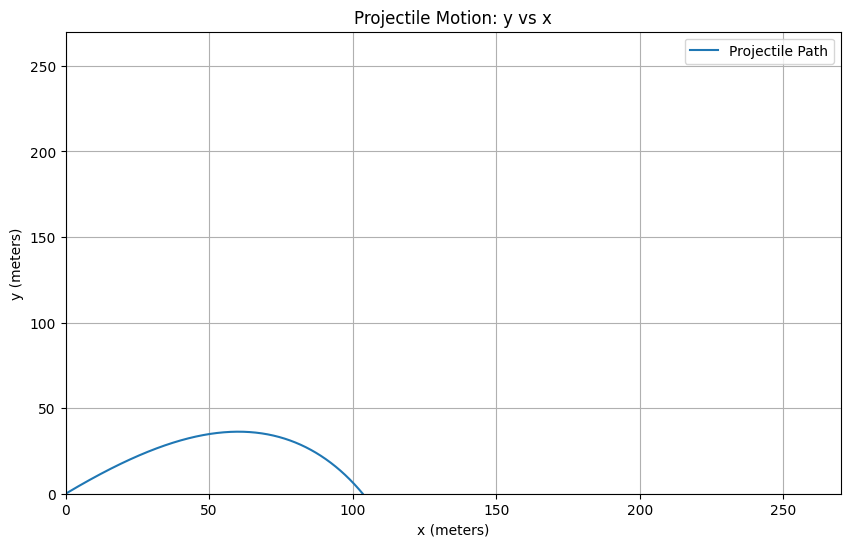

In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial 

# Constants

m = 0.145  # Mass (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
dt = 0.01  # Time step (s)



# Event function to stop integration when y < 0
def event_y_below_zero(t, state):
    return state[1]  # state[1] is y

event_y_below_zero.terminal = True
event_y_below_zero.direction = -1

C_d = 0.047  # Drag coefficient
rho = 1.225  # Air density (kg/m^3)
A = 0.045  # Cross-sectional area (m^2)

def drag(t, vx, vy):
    """Compute the drag force"""
    v = np.sqrt(vx**2 + vy**2) # Magnitude of velocity vector
    F_d = 0.5 * C_d * rho * A * v**2
    
    return F_d


def projectile_motion(m, drag_f, t, state):
    x, y, vx, vy = state
    
    v = np.sqrt(vx**2 + vy**2) # Magnitude of velocity vector
    
    F_d = drag_f(t, vx, vy)

    # v_x/v is the cos of the angle of the velocity vector
    # so this is -F_d*cos(v)
    ax = -F_d * vx / (m * v)

    #v_y/v is the sin of the angle of the velocity vector
    ay = -g - (F_d * vy / (m * v))
    
    return [vx, vy, ax, ay ]

def throw(v0, angle, drag_f):
    """Solve a trajectory for an initial velocity and angle"""
    
    angle_rad = np.radians(angle)
    
    # Initial velocity components
    vx0 = v0 * np.cos(angle_rad)
    vy0 = v0 * np.sin(angle_rad)
    
    x0 = 0    # Initial x position (m)
    y0 = 0    # Initial y position (m)
    
    # Initial state
    initial_state = [x0, y0, vx0, vy0]
    
    # Time span
    t_span = (0, 50)  # 50 seconds
    t_eval = np.arange(0, 50, dt)

    f = partial(projectile_motion, m, drag_f)
    
    solution = solve_ivp(f, t_span, initial_state, t_eval=t_eval, events=event_y_below_zero)

    t = solution.t
    x, y, vx, vy = solution.y # Unpack the states
    
    # Calculate drag force and accelerations for each time step
    # We have to re-calc these b/c they are hard to pass out of projectile_motion() through solve_ivp()
    # However, note that these equations are working with vectors, not scalars like they were in 
    # projectile_motion()

    # drag_v = np.vectorize(drag)
    
    F_d = drag_f(t, vx, vy)
    
    v = np.sqrt(vx**2 + vy**2)
    ax = -F_d * vx / (m * v)
    ay = -g - (F_d * vy / (m * v))
    
    # Create a pandas DataFrame
    
    data = {
        't': t,
        'x': x,
        'y': y,
        'vx': vx,
        'vy': vy,
        'ax': ax,
        'ay': ay,
        'F_d': F_d
    }
    
    return pd.DataFrame(data)

df = throw(50, 45, drag)

print(len(df))

# Plot y vs x
plt.figure(figsize=(10, 6))
plt.plot(df['x'], df['y'], label='Projectile Path')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.ylim(0,270)
plt.xlim(0,270)
plt.title('Projectile Motion: y vs x')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
df

,t,x,y,vx,vy,ax,ay,F_d
0,0.00,0.000000,0.000000,35.355339,35.355339,-0.0,-9.81,0.0
1,0.01,0.353553,0.353063,35.355339,35.257239,-0.0,-9.81,0.0
2,0.02,0.707107,0.705145,35.355339,35.159139,-0.0,-9.81,0.0
3,0.03,1.060660,1.056246,35.355339,35.061039,-0.0,-9.81,0.0
4,0.04,1.414214,1.406366,35.355339,34.962939,-0.0,-9.81,0.0
...,...,...,...,...,...,...,...,...
716,7.16,253.144228,1.686460,35.355339,-34.884261,-0.0,-9.81,0.0
717,7.17,253.497781,1.337127,35.355339,-34.982361,-0.0,-9.81,0.0
718,7.18,253.851334,0.986812,35.355339,-35.080461,-0.0,-9.81,0.0
719,7.19,254.204888,0.635517,35.355339,-35.178561,-0.0,-9.81,0.0


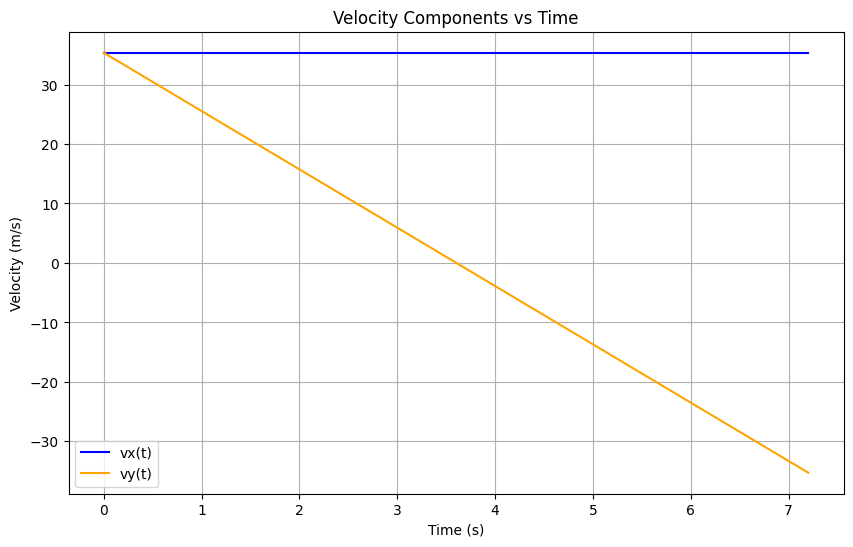

In [4]:
import matplotlib.pyplot as plt

# Plotting vx and vy versus time on the same axes
plt.figure(figsize=(10, 6))

plt.plot(df['t'], df['vx'], label='vx(t)', color='blue')
plt.plot(df['t'], df['vy'], label='vy(t)', color='orange')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Components vs Time')
plt.legend()
plt.grid(True)

plt.show()
